In [1]:
# Di Google Colab
from google.colab import files
uploaded = files.upload() # Upload file kaggle.json Anda

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset IAM Handwriting
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/validation_v2/validation/VALIDATION_5003.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5004.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5005.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5006.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5007.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5008.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5009.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5010.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5011.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5012.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5013.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5014.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5015.jpg  
  inflating: data/validation_v2/validation/VALIDATION_5016.jpg  
  inflating: data/validation_v2/validat

In [ ]:
#!pip install opencv-python
#!pip install keras
#!pip install tensorflow

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam


# DATA PREPARATION - DATA COLLECTION



In [2]:
# Change your directory path here
base_path = '/content/data'
# Load training and validation datasets
print("=== DATA COLLECTION ===")
train = pd.read_csv(base_path+'/written_name_train_v2.csv')
valid = pd.read_csv(base_path+'/written_name_validation_v2.csv')

print(f"Training samples: {len(train)}")
print(f"Validation samples: {len(valid)}")
print(f"Training columns: {train.columns.tolist()}")

=== DATA COLLECTION ===
Training samples: 330961
Validation samples: 41370
Training columns: ['FILENAME', 'IDENTITY']


# DATA PREPARATION - DATA ANALYSIS (EXPLORATORY DATA ANALYSIS)


=== DATA ANALYSIS ===
Dataset Info:
Train dataset shape: (330961, 2)
Validation dataset shape: (41370, 2)

Sample data:
          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

Displaying sample handwritten names...


<Figure size 1500x1000 with 0 Axes>

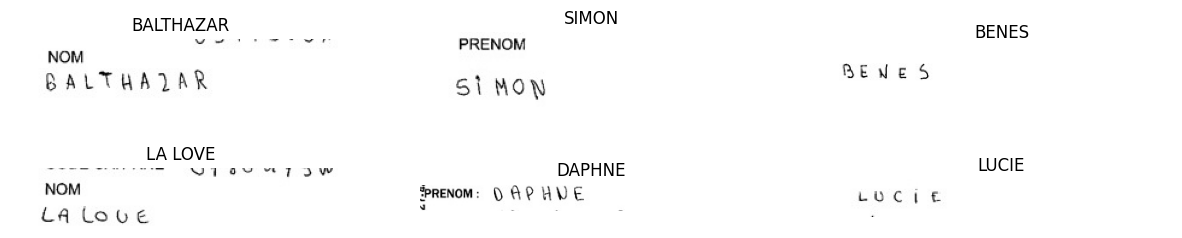

In [3]:
print("\n=== DATA ANALYSIS ===")

# Display basic dataset information
print("Dataset Info:")
print(f"Train dataset shape: {train.shape}")
print(f"Validation dataset shape: {valid.shape}")
print("\nSample data:")
print(train.head())

# Visualize sample images from training set
plt.figure(figsize=(15, 10))
print("\nDisplaying sample handwritten names...")

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = base_path+'/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [4]:
# Analyze data quality - check for missing values
print(f"\nData Quality Analysis:")
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

# Analyze label distribution
print(f"\nLabel Analysis:")
print(f"Unique labels in training: {train['IDENTITY'].nunique()}")
print(f"Most common labels:")
print(train['IDENTITY'].value_counts().head(10))



Data Quality Analysis:
Number of NaNs in train set      :  565
Number of NaNs in validation set :  78

Label Analysis:
Unique labels in training: 100539
Most common labels:
IDENTITY
THOMAS     1825
EMPTY      1796
LEA        1582
EMMA       1482
LUCAS      1479
HUGO       1367
CAMILLE    1367
CLEMENT    1313
MANON      1277
LOUIS      1257
Name: count, dtype: int64


# DATA PREPARATION - DATA PREPROCESSING

In [5]:
print("\n=== DATA PREPROCESSING ===")

# Remove NaN values from both datasets
print("Removing NaN values...")
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

# Analyze unreadable samples
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

print(f"Found {len(unreadable)} unreadable samples")



=== DATA PREPROCESSING ===
Removing NaN values...
Found 102 unreadable samples


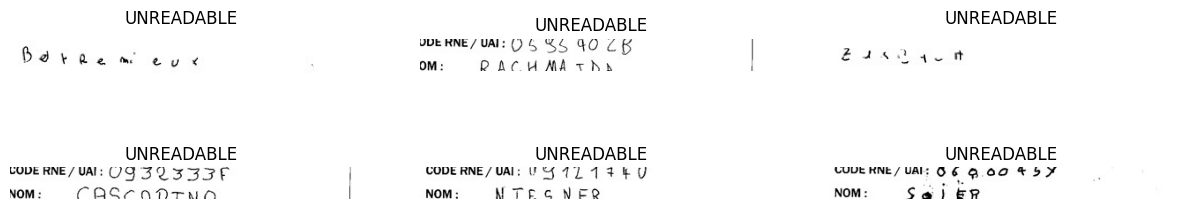

In [6]:
# Visualize unreadable samples
if len(unreadable) > 0:
    plt.figure(figsize=(15, 10))
    for i in range(min(6, len(unreadable))):
        ax = plt.subplot(2, 3, i+1)
        img_dir = base_path+'/train_v2/train/'+unreadable.loc[i, 'FILENAME']
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap = 'gray')
        plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=-0.8)
    plt.show()

In [7]:
# Remove unreadable samples
print("Removing unreadable samples...")
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

# Normalize text labels to uppercase
print("Normalizing text labels to uppercase...")
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

# Reset indices after filtering
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

print(f"After preprocessing - Train: {len(train)}, Valid: {len(valid)}")

Removing unreadable samples...
Normalizing text labels to uppercase...
After preprocessing - Train: 330294, Valid: 41280


#  DATA PREPARATION - FEATURE ENGINEERING

In [8]:
def preprocess(img):
    """
    Image preprocessing function for feature engineering
    - Standardizes image size to 64x256 pixels
    - Handles variable image dimensions
    - Applies padding and rotation for optimal model input
    """
    (h, w) = img.shape

    # Create blank white canvas with standard size
    final_img = np.ones([64, 256])*255 # 64 height, 256 width

    # Crop image if it exceeds maximum dimensions
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]

    # Place original image on the canvas
    final_img[:h, :w] = img

    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [9]:
# Define character set for encoding
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # Maximum length of input labels
num_of_characters = len(alphabets) + 1 # +1 for CTC pseudo blank
num_of_timestamps = 64 # Maximum length of predicted labels

print(f"Character set: {alphabets}")
print(f"Number of characters: {num_of_characters}")
print(f"Maximum string length: {max_str_len}")

Character set: ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 
Number of characters: 30
Maximum string length: 24


In [10]:
def label_to_num(label):
    """
    Convert text label to numerical sequence
    Feature engineering for text labels
    """
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)

def num_to_label(num):
    """
    Convert numerical sequence back to text label
    Inverse feature engineering for model output
    """
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret+=alphabets[ch]
    return ret

# Test feature engineering functions
name = 'NAUFAL'
print(f"\nFeature Engineering Test:")
print(f"Original: {name}")
print(f"Encoded: {label_to_num(name)}")
print(f"Decoded: {num_to_label(label_to_num(name))}")


Feature Engineering Test:
Original: NAUFAL
Encoded: [13  0 20  5  0 11]
Decoded: NAUFAL


# DATA PREPARATION - FEATURE SELECTION

In [11]:
train_size = 20000
valid_size= 3000

In [12]:
print("Processing training images...")
train_x = []

for i in range(train_size):
    img_dir = base_path+'/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

Processing training images...


In [14]:
print("Processing validation images...")
valid_x = []

# Remove the second loop that appends to valid_x
for i in range(valid_size):
    img_dir = base_path+'/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

# Reshape arrays for model input (feature reshaping)
# Now valid_x will have valid_size (3000) samples
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

print(f"Training features shape: {train_x.shape}")
print(f"Validation features shape: {valid_x.shape}")

Processing validation images...
Training features shape: (20000, 256, 64, 1)
Validation features shape: (3000, 256, 64, 1)


# MODEL DEVELOPMENT - LABEL ENCODING


LABEL ENCODING AND PREPARATION:
- Convert text labels to numerical format
- Prepare input/output lengths for CTC loss
- Create training-ready label arrays


In [15]:
# Prepare training labels
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

print("Encoding training labels...")
for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

Encoding training labels...


In [16]:
# Prepare validation labels with same process
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

print("Validation training labels...")
for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

Validation training labels...


In [17]:
# Display label encoding example
print(f"\nLabel Encoding Example:")
print('True label : ',train.loc[100, 'IDENTITY'])
print('Encoded label : ',train_y[100])
print('Label length : ',train_label_len[100])
print('Input length : ', train_input_len[100])


Encoding validation labels...

Label Encoding Example:
True label :  NOUR
Encoded label :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.]
Label length :  [4.]
Input length :  [62.]


 MODEL ARCHITECTURE DESIGN

- CNN layers for feature extraction from images
- RNN layers for sequence modeling

In [18]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
from tensorflow.keras.backend import ctc_batch_cost # Import from TensorFlow Keras backend
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    # Use the imported ctc_batch_cost directly
    return ctc_batch_cost(labels, y_pred, input_length, label_length)


In [20]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

MODEL COMPILATION AND TRAINING SETUP

# MODEL TRAINING

In [21]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=50, batch_size=100)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 231ms/step - loss: 44.3527 - val_loss: 22.1387
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 20.3165 - val_loss: 20.2847
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 225ms/step - loss: 20.0260 - val_loss: 20.1385
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 19.7675 - val_loss: 19.6761
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - loss: 19.3379 - val_loss: 19.2404
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 218ms/step - loss: 18.5702 - val_loss: 17.7371
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - loss: 17.4317 - val_loss: 16.1383
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 220ms/step - loss: 15.8054 - val_loss: 14.5519
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - loss: 13.9474 - val_loss: 12.4644
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 221ms/step - loss: 11.9267 - val_loss: 10.1878
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 9.6950 - val_loss: 8.6729

# MODEL EVALUATION AND PERFORMANCE METRICS

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K # Import Keras backend from TensorFlow

preds = model.predict(valid_x)
# Use tf.keras.backend.get_value instead of K.get_value
decoded = tf.keras.backend.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


# Display performance results

In [23]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 86.27%
Correct words predicted      : 70.50%



=== SAMPLE PREDICTIONS ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


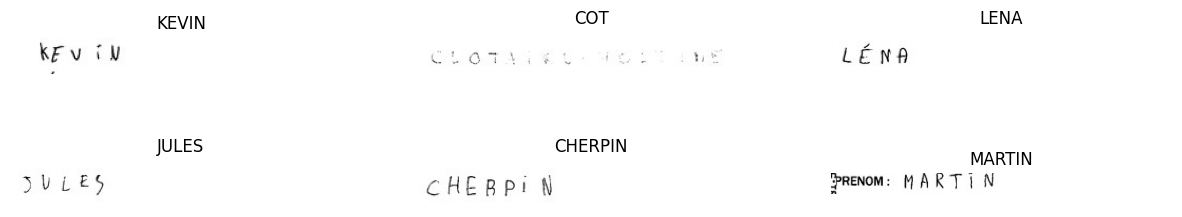

In [24]:
test = pd.read_csv(base_path+'/written_name_test_v2.csv')
print(f"\n=== SAMPLE PREDICTIONS ===")
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = base_path+'/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [28]:
from keras.models import save_model

# Save the model using the recommended .keras format
save_model(model, "/content/model/model50v2.h5")

In [29]:
# Save the model using the recommended .keras format
save_model(model, "/content/model/model50v2.keras")

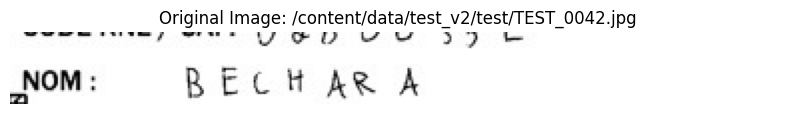

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Predicted text is: BECHARA


In [31]:
# Load the saved model
import tensorflow as tf
from keras.models import load_model
loaded_model = load_model("/content/model/model50v3.keras", compile=False)

# You can now use 'loaded_model' for predictions or further evaluation
# For example, you could predict on a single image:
img_path = base_path+'/test_v2/test/TEST_0042.jpg'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Add a check to see if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {img_path}. Please check the file path and ensure the file exists and is not corrupted.")
else:
    # Display the image
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f"Original Image: {img_path}")
    plt.axis('off')
    plt.show()

    image = preprocess(image)
    image = image/255.
    prediction = loaded_model.predict(image.reshape(1, 256, 64, 1))
    input_length_for_decode = np.array([prediction.shape[1]])

    decoded = K.get_value(K.ctc_decode(prediction, input_length=input_length_for_decode,
                                   greedy=True)[0][0])
    predicted_text = num_to_label(decoded[0])

    # Print the predicted text
    print(f"Predicted text is: {predicted_text}")
